## Q1: Newton's Method (20 pts)

In [1]:
using Pkg;
const root = dirname(@__DIR__)
Pkg.activate(root);
Pkg.instantiate()

  Activating environment at `~/devel/dynamics-simulation-16-715/HW3_solutions/Project.toml`


In [2]:
using LinearAlgebra, ForwardDiff, Plots, Test
const FD = ForwardDiff
using JLD2, FileIO
const jld2path = joinpath(root,"test");

## 1A: Newton's method in 1 dimension (2pts)
First let's look at a nonlinear function, and label where this function is equal to 0 (a root of the function).

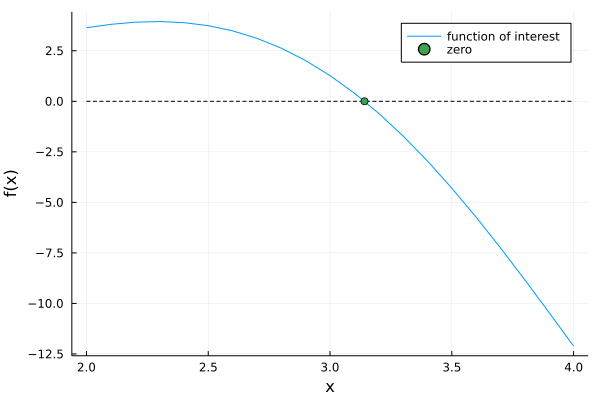

In [6]:
let 
    x = 2:0.1:4;
    y = sin.(x) .* x.^2
    plot(x,y,label = "function of interest")
    plot!(x,0*x,linestyle = :dash, color = :black,label = "")
    xlabel!("x")
    ylabel!("f(x)")
    scatter!([pi],[0],label = "zero")
end

We are now going to use Newton's method to numerically evaluate the argument $x$ where this function is equal to zero. To make this more general, let's define a residual function,
$$ r(x) = \sin(x)x^2. $$
We want to drive this residual function to be zero (aka find a root to $r(x)$). To do this, we start with an initial guess at $x_k$, and approximate our residual function with a first-order Taylor expansion:
$$ r(x_k + \Delta x) \approx r(x_k) + \bigg[ \frac{\partial r}{\partial x}\bigg\rvert_{x_k} \bigg] \Delta x. $$ 
We now want to find the root of this linear approximation. In other words, we want to find a $\Delta x$ such that $r(x_k + \Delta x) = 0$. To do this, we simply re-arrange:
$$ \Delta x = -\bigg[ \frac{\partial r}{\partial x}\bigg\rvert_{x_k} \bigg]^{-1}r(x_k). $$ 
We can now increment our estimate of the root with the following:
$$ x_{k+1} = x_k + \Delta x$$
We have now described one step of Netwon's method. We started with an initial point, linearized the residual function, and solved for the $\Delta x$ that drove this linear approximation to zero. We keep taking Newton steps until $r(x_k)$ is close enough to zero for our purposes (usually not hard to drive below 1e-10). 


Julia tip: `x=A\b` solves linear systems of the form $Ax = b$ whether $A$ is a matrix or a scalar. 

Test Summary: | Pass  Total
1d            |    1      1


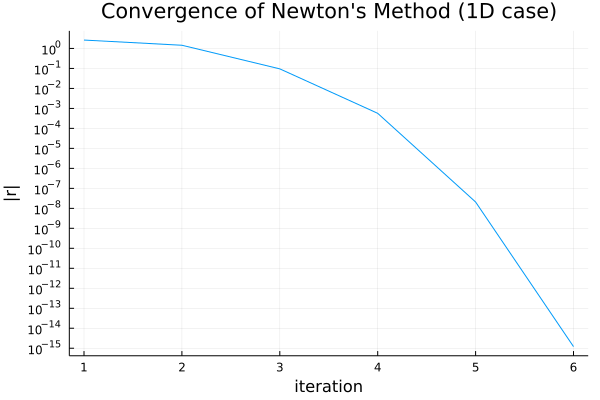

In [7]:
let 
    # residual function 
    r(_x) = sin(_x)*_x^2
    
    # vectors for storing the x_k's and r(x_k)'s
    X = NaN*ones(10)
    R = NaN*ones(10)
    
    # initial point NOTE: Newton's method always needs an initial point.
    X[1] = 2.8
    R[1] = r(X[1])
    
    # TODO: use Newton's method to find the x such that r(x) = 0 
    # store x values in X, R values in R 
    # hint: R[i] = r(X[i]) at each iteration
    

    # TODO: trim the NaN's from your X and R (here I trimmed to the first 6) 
    R = R[1:6]
    X = X[1:6]
    
    # tests
    @testset "1d" begin 
        @test norm(r(X[end]))<1e-7
    end
    
    # plotting
    plot(norm.(R),yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method (1D case)",label = "")
    
end

When the initial point is within a "basin of attraction", Newton's method has quadratic convergence. 

## 1B: Newton's method in multiple variables (3 pts)
We are now going to use Newton's method to solve for the zero of a multivariate function.

Test Summary: | Pass  Total
3d            |    1      1


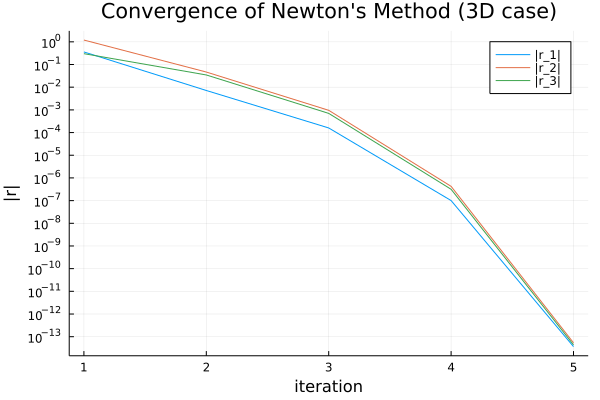

In [8]:
let 
    # residual function 
    r(x) = [sin(x[3] + 0.3)*cos(x[2]- 0.2) - 0.3*x[1];
            cos(x[1]) + sin(x[2]) + tan(x[3]);
            3*x[1] + 0.1*x[2]^3]
    
    # vectors for storing the x_k's and r(x_k)'s
    X = NaN*[zeros(3) for i = 1:10]
    R = NaN*[zeros(3) for i = 1:10]
    
    # initial point NOTE: Newton's method always needs an initial point.
    X[1] = [.1;.1;0.1]
    R[1] = r(X[1])
    
    # TODO: use Newton's Method again to find x st r(x) = zeros(3)
    
        
    # trim the NaN's away (mine converged in 5 iterations)
    R = R[1:5]    
    X = X[1:5]
    Rp = [[abs(R[i][ii]) for i = 1:length(R)] for ii = 1:3] # this gets abs of each term at each iteration
    
    # tests 
    @testset "3d" begin 
        @test norm(r(X[end]))<1e-7;
    end
    
    # convergence plotting 
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method (3D case)",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    plot!(Rp[3],label = "|r_3|")

end

## 1C: Newtons method in optimization (5 pts)
Now let's look at how we can use Newton's method in numerical optimization. Let's start by plotting a cost function $f(x)$, where $x\in \mathbb{R}^2$.

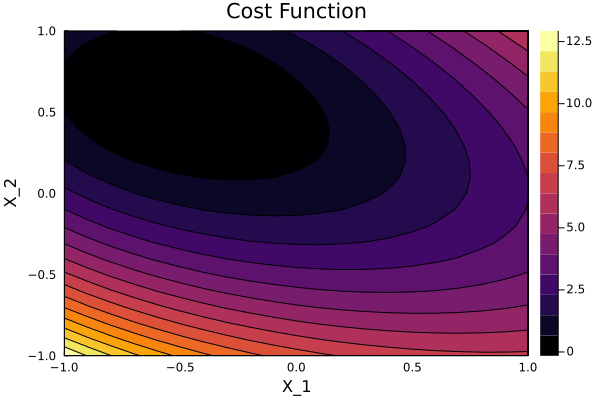

In [9]:
let
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    f(x) = 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2) # cost function 
    contour(-1:.1:1,-1:.1:1, (x1,x2)-> f([x1;x2]),title = "Cost Function",
            xlabel = "X_1", ylabel = "X_2",fill = true)
end

To find the minimum for this cost function $f(x)$, let's write the KKT conditions for optimality:
$$ \nabla f(x) = 0 \quad \quad \text{stationarity}, $$
which we see is just another rootfinding problem. We are now going to use Newton's method on the KKT conditions to find the $x$ in which $\nabla f(x) = 0$.  

Test Summary:              | Pass  Total
unconstrained optimization |    1      1


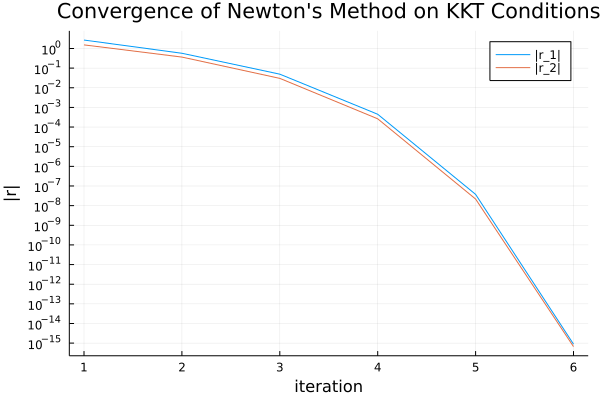

In [10]:
let 
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    f(x) = 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
    
    function kkt_conditions(x)
        
        # TODO: return the stationarity condition for the cost function f (∇f(x))
        
        return FD.gradient(f,x)
    end
    
    # the residual function we are driving to zero 
    r(x) = kkt_conditions(x)
    
    # vectors for storing the x_k's and r(x_k)'s
    X = NaN*[zeros(2) for i = 1:10]
    R = NaN*[zeros(2) for i = 1:10]
    
    # initial point NOTE: Newton's method always needs an initial point.
    X[1] = [-0.9512129986081451, 0.8061342694354091]
    R[1] = r(X[1])
    
    # TODO: use Newton's Method to find x st r(x) = zeros(3)
    
    
    # trim the NaN's away (you can change this number if you need to, but you shouldn't have to )
    R = R[1:6]
    X = X[1:6]
    Rp = [[abs(R[i][ii]) for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    # tests 
    @testset "unconstrained optimization" begin 
        @test norm(r(X[end]))<1e-7;
    end
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
end


## 1D: Constrained optimization (5 pts)
Now let's see how this works for constrained optimization. For the following optimization problem,
$$ \min_x f(x) $$ 
$$ \text{st} \quad c(x) = 0. $$
Here we will plot this cost function, with the constraint as a circle shown in blue.



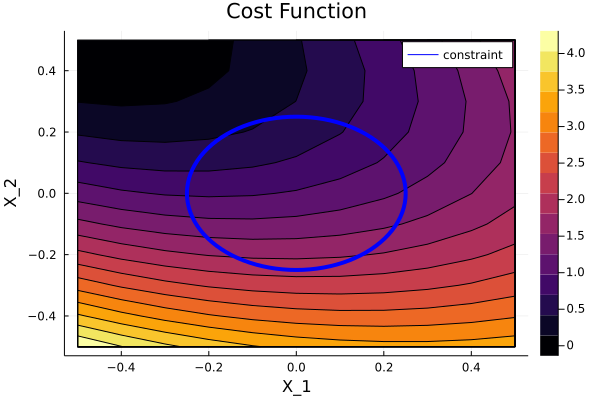

In [11]:
# don't touch this cell
function circle(xc,yc,r)
    θ = (0:0.01:1)*2*pi
    x = xc .+ r*cos.(θ)
    y = yc .+ r*sin.(θ)
    return x,y
end
let
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    f(x) = 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2) # cost function 
    contour(-0.5:.1:0.5,-0.5:.1:0.5, (x1,x2)-> f([x1;x2]),title = "Cost Function",
            xlabel = "X_1", ylabel = "X_2", zlabel = "Cost",fill = true)
    
    xc,yc = circle(0,0,0.25)
    plot!(xc,yc,label="constraint",lw = 4, color = :blue)
end

We can write out the KKT conditions for this problem as:
$$ \begin{align} \nabla f(x) + \lambda \nabla c(x) &= 0 \quad \quad \text{stationarity} \\ 
 c(x) &= 0 \quad \quad \text{primal feasibility}
 \end{align}$$
 Once again we will solve for the variables $x \in \mathbb{R}^2$ and $\lambda \in \mathbb{R}$ using Newton's method. First we will stack these up in a vector $z$,
 $$ z = \begin{bmatrix}x \\ \lambda \end{bmatrix}, $$
 then put the kkt conditions in the function $r(z)$, and use Newton's method as we have previously.

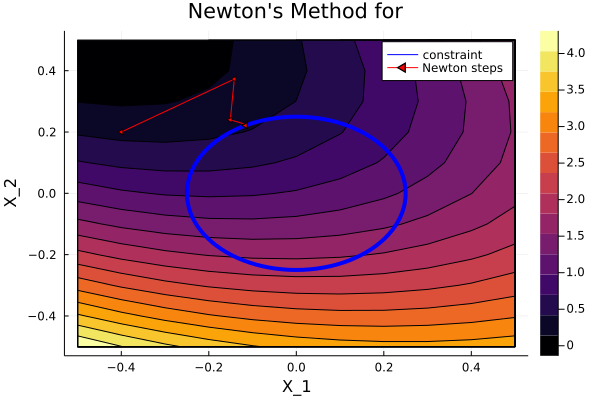

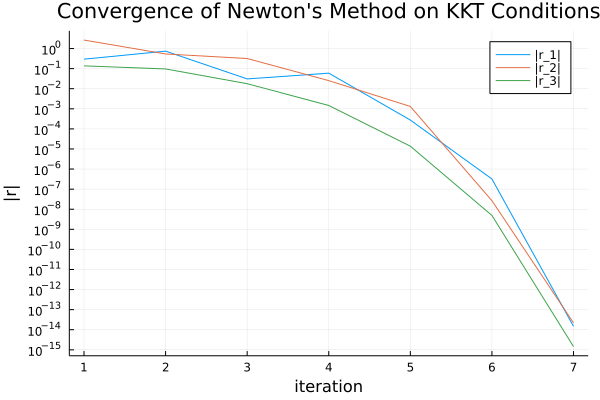

Test Summary:            | Pass  Total
constrained optimization |    1      1


In [12]:
let 
    
    # constraint (must be a distance of 0.25 from the origin)
    c(x) = dot(x,x) - 0.25^2
    
    # cost function
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    f(_x) = 0.5*_x'*Q*_x + q'*_x + exp(-1.3*_x[1] + 0.3*_x[2]^2)
    
    # kkt conditions
    function kkt_conditions(z)
        """
        calculate the residual of the KKT conditions for the given problem. 
        
        inputs:
            z = [x[1];x[2];λ]
        
        outputs: 
            [stationarity; primal_feasibility] # this is a column vector
        """
        x = copy(z[1:2])
        λ = copy(z[3])
        
        # TODO: calculate the stationariy and primal feasiblity conditions
        
        return NaN
    end
    
    # the residual function we are driving to zero 
    r(z) = kkt_conditions(z)
    
    
    # vectors for storing the x_k's and r(x_k)'s
    max_newton_steps = 10;
    Z = NaN*[zeros(3) for i = 1:max_newton_steps]
    R = NaN*[zeros(3) for i = 1:max_newton_steps]
    
    # initial point NOTE: Newton's method always needs an initial point.
    Z[1] = [-.4;.2;.001]
    R[1] = r(Z[1])
    
    # TODO: use Newton's Method to find the z = [x;λ] that satisfies r(z) = zeros(3)
    
 
    # trim the NaN's
    N = 7;
    R = R[1:N]
    Z = Z[1:N]
    
    @testset "constrained optimization" begin 
        @test norm(r(Z[end]))<1e-7 
    end
    
    Zm = zeros(3,N)
    for i = 1:N
        Zm[:,i] = Z[i]
    end
    # plot newton steps on cost function 
    (contour(-0.5:.1:0.5,-0.5:.1:0.5, (x1,x2)-> f([x1;x2]),title = "Newton's Method for",
            xlabel = "X_1", ylabel = "X_2", zlabel = "Cost",fill = true))
    
    xc,yc = circle(0,0,0.25)
    (plot!(xc,yc,label="constraint",lw = 4, color = :blue))
    display(plot!(Zm[1,:],Zm[2,:],color = :red,markershape = :ltriangle, label = "Newton steps"))
    
    # plot convergence stuff
    Rp = [[abs(R[i][ii])+1e-15 for i = 1:length(R)] for ii = 1:length(R[1])]
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    @show 
end

## 1E: Newton's method with quaternions (5 pts)
Now we are going to use Newton's method to minimize a scalar cost function with a quaternion input.
$$ \min_q w(q) $$
To calculate the KKT conditions for this problem, normally we would have $ \nabla w(q) = 0$, but since we are dealing with quaternions, we will use the attitude Jacobian to convert this from a 4 parameter representation to a 3 parameter representation. 
$$ \bigg[ \frac{\partial w}{\partial q} G(q)\bigg]^T = 0, $$
Keep in mind that `FD.gradient` will return a column vector, so we have to transpose it to get $\frac{\partial w}{\partial q}$.  

You will now use Newton's method to find the quaternion $q$ such that the above stationarity condition is satisfied. There are two adjustments that must be made to Newton's method to accommodate quaternions. 

1. Remember to append the attitude jacobian ($G(q)$) to the right hand side of the Jacobian in each Newton step 
2. The resulting Newton step direction ($\phi$), is applied multiplicatively through $q_{k+1} = L(q_k) \rho(\phi)$

The $\rho(\phi)$ function simply maps $\phi$ to quaternions in the following way:
$$ \rho(\phi) = \frac{1}{\sqrt{1 + \|\phi\|^2}} \begin{bmatrix} 1 \\ \phi \end{bmatrix} $$
There is more info on this [here](https://roboticexplorationlab.org/papers/planning_with_attitude.pdf).

In [13]:
#Some standard functions for dealing with rotation matrices and quaternions from the class notes
function hat(ω)
    [0    -ω[3]   ω[2];
     ω[3]    0   -ω[1];
    -ω[2]  ω[1]     0]
end

function L(q)
    [q[1] -q[2:4]'; q[2:4] q[1]*I + hat(q[2:4])]
end

function R(q)
    [q[1] -q[2:4]'; q[2:4] q[1]*I - hat(q[2:4])]    
end
function G(q)
    # attitude jacobian
    return L(q)*H
end
function ρ(ϕ)
    # convert from ϕ to a quaternion
    return (1/sqrt(1 + dot(ϕ,ϕ)))*[1;ϕ]
end

const H = [zeros(1,3); I];

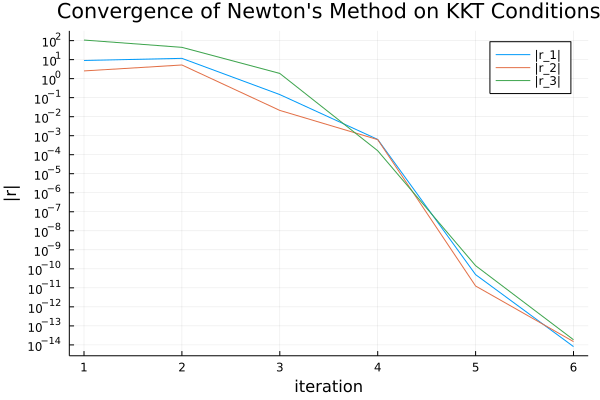

Test Summary:     | Pass  Total
quaternion Newton |    1      1


In [14]:
let 

    # rotation matrix from quaternion 
    Q_fx(_q) = H'*L(_q)*R(_q)'*H

    
    function w(q,Y_N,Y_B)
        # This is a scalar cost function that takes a quaternion as an input. The cost function 
        # puts a quadratic penalty on the difference between known inertial vectors Y_N, and 
        # the body frame measurements Y_B, after they've been rotated into the inertial frame. 
        
        # this is basically the least squares version for SO(3) given known and measured unit vectors.
        J = zero(eltype(q))
        Q = Q_fx(q)
        for i = 1:length(Y_N)
            J += (Q*Y_B[i] - Y_N[i])'*(Q*Y_B[i] - Y_N[i])
        end
        return J 
    end
    

    # load in data 
    test_dict = load(joinpath(jld2path,"q1.jld2"))
    Y_N = test_dict["Y_N"]
    Y_B = test_dict["Y_B"]
    qk = test_dict["qk"]
    
    # KKT conditions for the problem 
    function kkt_conditions(q,Y_N,Y_B)
        
        ## TODO: output the KKT conditions
        return NaN
    end
    
    # define our residual 
    r(_q) = kkt_conditions(_q,Y_N,Y_B)
    
    # vectors for storing the x_k's and r(x_k)'s
    Xs = NaN*[zeros(3) for i = 1:10]
    Rs = NaN*[zeros(3) for i = 1:10]
    
    # initial point NOTE: Newton's method always needs an initial point.
    Xs[1] = copy(qk)
    Rs[1] = r(Xs[1])
    
    # TODO: use Newton's method on the residual function r(q)
    # hint: you will need to modify Newton's method using the above 2 tips given above
    
    # trim out the NaN's 
    Rs = Rs[1:6]
    Xs = Xs[1:6]
    
    @testset "quaternion Newton" begin 
        @test norm(Rs[end])<1e-10 
    end
    
    # plotting stuff 
    Rp = [[abs(Rs[i][ii])+1e-15 for i = 1:length(Rs)] for ii = 1:length(Rs[1])]
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
        
        
end